<a href="https://colab.research.google.com/github/JAlonMor/Webscraping/blob/main/MODEL_coches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Clonar repositorio de GitHub si no está disponible

import os
curr_dir = os.getcwd()

if not os.path.exists(os.path.join(curr_dir, '../.ROOT_DIR')):
  !git clone https://github.com/JAlonMor/Webscraping.git
  os.chdir(os.path.join(curr_dir, 'Webscraping/EDA'))

fatal: destination path 'Webscraping' already exists and is not an empty directory.


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer , TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR


# Amplio límtes de visualización
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

In [11]:
# Creo DataFrame a partir de los datos obtenidos mediante web scraping

model_coches = pd.read_csv("/content/Webscraping/EDA/cochesEDA_Output.csv")

In [12]:
model_coches.head()

,precio,kilometros,garantia,AMG,años,gasolina,hibrido,hib_enchufable,tipo_200,tipo_220,tipo_250,tipo_300,tipo_350,tipo_400,tipo_43,tipo_45,tipo_450,tipo_63,tipo_NoInfo,coupe,berlina,ranchera,4MATIC,Avantgarde,BlueTEC,Sportive,Exclusive,S_Edition,d_Edition
0,16200,281000,0,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,26900,114336,1,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,11000,287500,0,0,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,22900,110000,1,0,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,68000,10650,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Histograma "Log_precio"')

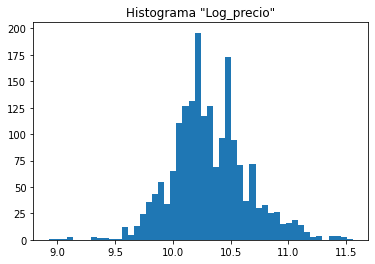

In [13]:
# Mostramos "precio" con transformación logarítmica
log_precio = np.log(model_coches.precio)
plt.hist(log_precio, bins = 50);
plt.title('Histograma "Log_precio"')

Pipelines

Precio --> logaritmo de Precio ,
kilometros --> MinMaxScaler ,
año --> MinMAxScaler


In [14]:
# convertimos el DataFrame al formato necesario para scikit-learn
data_backUp = model_coches.copy()


y = model_coches['precio']     # nos quedamos con la 1ª columna
X = model_coches.drop(columns = 'precio')      # nos quedamos con el resto

feature_names = model_coches.columns[1:]

In [15]:
# Dividimos los datos en entrenamiento y test (75% training, 25% test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

Datos entrenamiento:  (1445, 28)
Datos test:  (482, 28)


In [16]:
# Crear funciones logarítmica y exponencial para aplicar posteriormente sobre la variable objetivo a través de Pipelines

def func(x):
  '''Función logarítmica
  '''
  return np.log(x)

def inverse_func(x):
  '''Función exponencial
  '''
  return np.exp(x)

In [17]:
# Pipelines

# Escalado de características 'años' y 'kilómetros'

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [('scale_data_Mx_mn', MinMaxScaler(),['años','kilometros'])])

# Aplicar escalado y transformación para realizar modelo RandomForestRegressor

model_pipeline = Pipeline(steps = [('pre_processing', pre_process),                                   
                                   ('random_forest', RandomForestRegressor(max_depth=10, random_state=2, bootstrap = True))])

# Aplicar transformación logarítmica a variable objetivo 'precio', procesar resto de Pipelines

model = TransformedTargetRegressor(regressor = model_pipeline,
                                   func = func,
                                   inverse_func = inverse_func)

In [18]:
# Entrenar modelo

model.fit(X_train, y_train)

TransformedTargetRegressor(func=<function func at 0x7f49870ffc20>,
                           inverse_func=<function inverse_func at 0x7f49870ffef0>,
                           regressor=Pipeline(steps=[('pre_processing',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale_data_Mx_mn',
                                                                                       MinMaxScaler(),
                                                                                       ['años',
                                                                                        'kilometros'])])),
                                                     ('random_forest',
                                                      RandomForestRegressor(max_depth=10,
                                                                            random_state=2))]))

In [19]:
# Evaluar modelo

model.score(X_test, y_test)

0.8827444638338343

Probamos diferentes parámetros para mejorar el modelo

Realizamos GridCV


best mean cross-validation score: 0.900
best parameters: {'max_depth': 16}


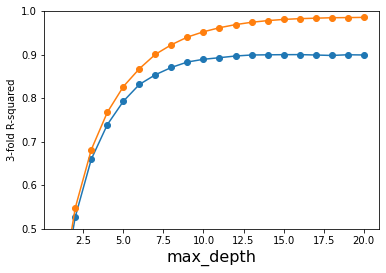

In [20]:
max_depth_arr = range(1, 20+1) 
tuned_parameters = {'max_depth': max_depth_arr} 
n_folds = 3 # ponemos este valor algo bajo para que no tarde demasiado 
clf = RandomForestRegressor(random_state=0, n_estimators=100, max_features='sqrt') 
grid = GridSearchCV(clf, param_grid=tuned_parameters, cv=n_folds, return_train_score=True) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_)) 
print("best parameters: {}".format(grid.best_params_)) 
scores_test = np.array(grid.cv_results_['mean_test_score']) 
scores_train = np.array(grid.cv_results_['mean_train_score']) 
plt.plot(max_depth_arr, scores_test, '-o', label='Validación') 
plt.plot(max_depth_arr, scores_train, '-o', label='Entrenamiento') 
plt.xlabel('max_depth', fontsize=16) 
plt.ylabel('{}-fold R-squared'.format(n_folds)) 
plt.ylim((0.5, 1)) 
plt.show()

Mejor parámetro: max_depth = 16

In [21]:
clf = RandomForestRegressor(random_state=0, n_estimators= 100, max_features = 'sqrt', max_depth=16)

Repetimos Pipelines

In [22]:
# Pipelines

# Escalado de características 'años' y 'kilómetros'

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [('scale_data_Mx_mn', MinMaxScaler(),['años','kilometros'])])

# Aplicar escalado y transformación para realizar modelo RandomForestRegressor

model_pipeline = Pipeline(steps = [('pre_processing', pre_process),                                   
                                   ('random_forest', clf)])

# Aplicar transformación logarítmica a variable objetivo 'precio', procesar resto de Pipelines

model = TransformedTargetRegressor(regressor = model_pipeline,
                                   func = func,
                                   inverse_func = inverse_func)

In [23]:
model.fit(X_train, y_train)

TransformedTargetRegressor(func=<function func at 0x7f49870ffc20>,
                           inverse_func=<function inverse_func at 0x7f49870ffef0>,
                           regressor=Pipeline(steps=[('pre_processing',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale_data_Mx_mn',
                                                                                       MinMaxScaler(),
                                                                                       ['años',
                                                                                        'kilometros'])])),
                                                     ('random_forest',
                                                      RandomForestRegressor(max_depth=16,
                                                                            max_features='sqrt',
          

In [24]:
R2_RFR = model.score(X_test, y_test)
R2_RFR

0.900329651288172

Analisis de los resultados

In [25]:
from sklearn.metrics import mean_squared_error

rms_RFR = mean_squared_error(y_test, model.predict(X_test), squared=False)
rms_RFR

3304.969540740131

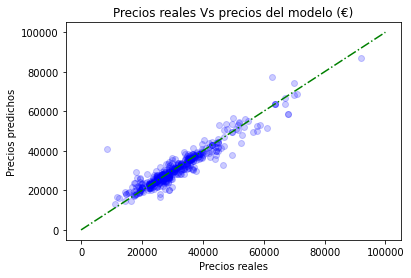

In [26]:
# Grafico para mejor comprensión de nuestras predicciones
plt.scatter(y_test, model.predict(X_test), color="blue", label = 'Precios', alpha=0.2)
plt.plot(range(100000), linestyle = 'dashdot', color = 'green')
plt.xlabel('Precios reales')
plt.ylabel('Precios predichos')
plt.title('Precios reales Vs precios del modelo (€)')
plt.show()

Modelo 2: GradientBoostingRefressor

Buscamos primero los mejores parámetros

In [27]:
from sklearn.ensemble import GradientBoostingRegressor 

Niterations = [10,100,500, 800] 
learningRate = [0.1, 0.05, 0.02] 
max_depth = [1,3,5,7,9]
n_folds = 3 
param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate, 'max_depth': max_depth} 
clf = GradientBoostingRegressor(random_state=0, max_depth=3) 
grid = GridSearchCV(clf, param_grid=param_grid, cv=n_folds) 
grid.fit(X_train, y_train) 
print("best mean cross-validation score: {:.3f}".format(grid.best_score_)) 
print("best parameters: {}".format(grid.best_params_))


best mean cross-validation score: 0.899
best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}


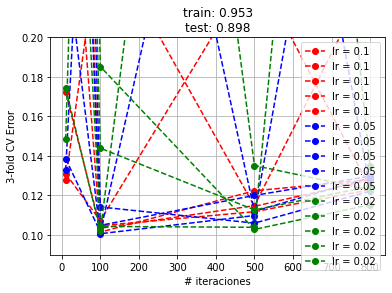

In [28]:
bt = GradientBoostingRegressor(random_state=0, **grid.best_params_) 
bt.fit(X_train, y_train) 
error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate), len(Niterations), len(max_depth)) 
colors = ['r', 'b', 'g', 'k', 'm'] 
for i, lr in enumerate(learningRate): 
  plt.plot(Niterations,error[i,:],colors[i] + '--o', label='lr = %g' % lr) 

plt.legend() 
plt.xlabel('# iteraciones') 
plt.ylabel('{}-fold CV Error'.format(n_folds)) 
plt.title('train: %0.3f\ntest: %0.3f' % (bt.score(X_train, y_train), bt.score(X_test, y_test))) 
plt.ylim(0.09,0.2)
plt.grid() 
plt.show()

Aplicamos mejores parámetros

In [29]:
# Tras probar con los valores max_depth=3 y max_depth=5, vemos que tenemos menor RMSE con 5

clf = GradientBoostingRegressor(random_state=0, n_estimators= 500, learning_rate = 0.05, max_features = 'sqrt', max_depth=5)

In [30]:
# Pipelines

# Escalado de características 'años' y 'kilómetros'

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [('scale_data_Mx_mn', MinMaxScaler(),['años','kilometros'])])

# Aplicar escalado y transformación para realizar modelo RandomForestRegressor

model_pipeline = Pipeline(steps = [('pre_processing', pre_process),                                   
                                   ('random_forest', clf)])

# Aplicar transformación logarítmica a variable objetivo 'precio', procesar resto de Pipelines

model = TransformedTargetRegressor(regressor = model_pipeline,
                                   func = func,
                                   inverse_func = inverse_func)

In [31]:
model.fit(X_train, y_train)

TransformedTargetRegressor(func=<function func at 0x7f49870ffc20>,
                           inverse_func=<function inverse_func at 0x7f49870ffef0>,
                           regressor=Pipeline(steps=[('pre_processing',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale_data_Mx_mn',
                                                                                       MinMaxScaler(),
                                                                                       ['años',
                                                                                        'kilometros'])])),
                                                     ('random_forest',
                                                      GradientBoostingRegressor(learning_rate=0.05,
                                                                                max_depth=5,
    

In [32]:
R2_GBR = model.score(X_test, y_test)
R2_GBR

0.9081637740292228

In [33]:
rms_GBR = mean_squared_error(y_test, model.predict(X_test), squared=False)
rms_GBR

3172.425897048429

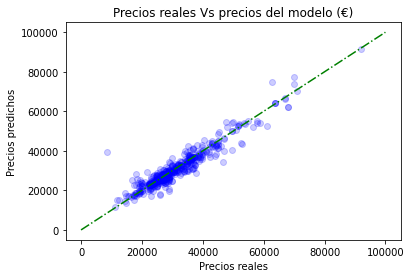

In [34]:
# Grafico para mejor comprensión de nuestras predicciones
plt.scatter(y_test, model.predict(X_test), color="blue", label = 'Precios', alpha=0.2)
plt.plot(range(100000), linestyle = 'dashdot', color = 'green')
plt.xlabel('Precios reales')
plt.ylabel('Precios predichos')
plt.title('Precios reales Vs precios del modelo (€)')
plt.show()

Modelo 3: Support Vector Regressor

In [36]:
vectorC = np.logspace(-2, 2, 10) 
vectorG = np.logspace(-5, 1, 8) 
param_grid = {'C': vectorC, 'gamma': vectorG} 
n_folds = 3 

grid = GridSearchCV(SVR(kernel='linear'), param_grid=param_grid, cv=n_folds, verbose=1) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_)) 
print("best parameters: {}".format(grid.best_params_))

Fitting 3 folds for each of 80 candidates, totalling 240 fits


KeyboardInterrupt: ignored

In [37]:
# Aplicamos parámetros obtenidos
clf = SVR(kernel = 'rbf', gamma = 1e-05, C = 100.0)

# Aplicamos parámetros obtenidos
clf = SVR(kernel = 'rbf', gamma = 1e-05, C = 100.0)

In [38]:
# Pipelines

# Escalado de características 'años' y 'kilómetros'

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [('scale_data_Mx_mn', MinMaxScaler(),['años','kilometros'])])

# Aplicar escalado y transformación para realizar modelo RandomForestRegressor

model_pipeline = Pipeline(steps = [('pre_processing', pre_process),                                   
                                   ('random_forest', clf)])

# Aplicar transformación logarítmica a variable objetivo 'precio', procesar resto de Pipelines

model = TransformedTargetRegressor(regressor = model_pipeline,
                                   func = func,
                                   inverse_func = inverse_func)

In [39]:
model.fit(X_train, y_train)

TransformedTargetRegressor(func=<function func at 0x7f49870ffc20>,
                           inverse_func=<function inverse_func at 0x7f49870ffef0>,
                           regressor=Pipeline(steps=[('pre_processing',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale_data_Mx_mn',
                                                                                       MinMaxScaler(),
                                                                                       ['años',
                                                                                        'kilometros'])])),
                                                     ('random_forest',
                                                      SVR(C=100.0,
                                                          gamma=1e-05))]))

In [40]:
R2_SVR = model.score(X_test, y_test)
R2_SVR

0.5829437092350545

In [41]:
rms_SVR = mean_squared_error(y_test, model.predict(X_test), squared=False)
rms_SVR

6760.546598781215

Con kernel = 'rbf' => R2 = 0.582943, RMS = 6760.5465